In [ ]:
# 0) SETUP & LOAD

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_PATH = "deliveries_updated_mens_ipl_upto_2024.xlsx"

# Helper: safe load for Excel/CSV with only needed columns
USECOLS = [
    'matchId','inning','over','ball','batsman','non_striker','bowler',
    'batting_team','bowling_team','batsman_runs','extras','isWide','isNoBall',
    'dismissal_kind','player_dismissed','date'
]

def load_deliveries(path):
    assert os.path.exists(path), f"File not found: {path}"
    if path.lower().endswith(".csv"):
        df = pd.read_csv(path, usecols=USECOLS, parse_dates=['date'])
    else:
        # Excel: read only required cols (faster than full read)
        df = pd.read_excel(path, usecols=USECOLS, parse_dates=['date'])
    return df

df = load_deliveries(DATA_PATH)
print("Shape:", df.shape)
df.head()

Shape: (260920, 16)


,matchId,inning,over,ball,batting_team,bowling_team,batsman,non_striker,bowler,batsman_runs,extras,isWide,isNoBall,dismissal_kind,player_dismissed,date
0,335982,1,0,1,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,BB McCullum,P Kumar,0,1,NaN,NaN,NaN,NaN,2008-04-18
1,335982,1,0,2,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,0,NaN,NaN,NaN,NaN,2008-04-18
2,335982,1,0,3,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,1,1.0,NaN,NaN,NaN,2008-04-18
3,335982,1,0,4,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,0,NaN,NaN,NaN,NaN,2008-04-18
4,335982,1,0,5,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,SC Ganguly,P Kumar,0,0,NaN,NaN,NaN,NaN,2008-04-18


In [ ]:
# 1) CLEAN & FEATURE ENGINEERING

# Strip strings
for c in ['batting_team','bowling_team','batsman','bowler','dismissal_kind','player_dismissed']:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip()

# Fill numeric nulls (rare but safe)
for c in ['batsman_runs','extras','isWide','isNoBall']:
    if c in df.columns:
        df[c] = df[c].fillna(0)

# Total runs in the delivery
df['total_runs'] = df['batsman_runs'] + df['extras']

# Flags
df['is_wide'] = (df['isWide'] == 1).astype(int)
df['is_noball'] = (df['isNoBall'] == 1).astype(int)
df['is_legal_delivery'] = (df['is_wide'] == 0) & (df['is_noball'] == 0)

# Phases (overs appear 0-indexed in this dataset)
def phase_from_over(o):
    if o <= 5: return 'Powerplay (1-6)'
    if 6 <= o <= 14: return 'Middle (7-15)'
    return 'Death (16-20)'
df['phase'] = df['over'].apply(phase_from_over)

# Convenience helpers
dismissal_exclude = {'run out','retired hurt','retired out','obstructing the field'}

# Lower-case dismissal_kind safely
dk = df['dismissal_kind'].astype(str).str.lower()
df['is_bowler_wicket'] = (~dk.isin(dismissal_exclude)) & (dk != 'nan')

print("Nulls by column:\n", df.isna().sum().sort_values(ascending=False).head(10))

Nulls by column:
 matchId              0
inning               0
phase                0
is_legal_delivery    0
is_noball            0
is_wide              0
total_runs           0
date                 0
player_dismissed     0
dismissal_kind       0
dtype: int64


In [ ]:
# 2) INSIGHT A: POWERPLAY

pp = df[(df['inning'].isin([1,2])) & (df['phase'] == 'Powerplay (1-6)')].copy()
pp['is_boundary'] = pp['batsman_runs'].isin([4,6])

team_pp = pp.groupby('batting_team').agg(
    runs=('total_runs','sum'),
    balls=('is_legal_delivery','sum'),
    boundaries=('is_boundary','sum'),
    matches=('matchId','nunique')
).reset_index()

# Filter for decent sample size
team_pp = team_pp[team_pp['matches'] >= 10].copy()
team_pp['overs'] = team_pp['balls'] / 6
team_pp['run_rate'] = team_pp['runs'] / team_pp['overs']
team_pp['boundary_pct'] = team_pp['boundaries'] / team_pp['balls']

team_pp = team_pp.sort_values('run_rate', ascending=False)
team_pp[['batting_team','matches','run_rate','boundary_pct']].head(12)

,batting_team,matches,run_rate,boundary_pct
17,Royal Challengers Bengaluru,15,9.715342,0.260628
4,Gujarat Lions,30,8.595941,0.224170
2,Delhi Capitals,91,8.570384,0.229738
12,Punjab Kings,56,8.430267,0.217112
14,Rising Pune Supergiant,16,8.177083,0.189236
18,Sunrisers Hyderabad,182,8.130329,0.198386
5,Gujarat Titans,45,8.049140,0.199631
7,Kochi Tuskers Kerala,14,8.015717,0.202358
8,Kolkata Knight Riders,251,7.881496,0.198610
9,Lucknow Super Giants,44,7.853996,0.188798


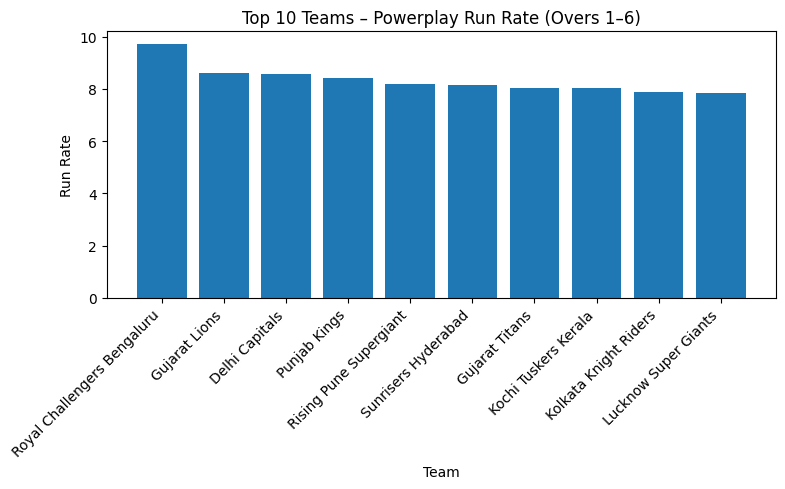

In [ ]:
top10_pp = team_pp.head(10)
plt.figure(figsize=(8,5))
plt.bar(top10_pp['batting_team'], top10_pp['run_rate'])
plt.title("Top 10 Teams – Powerplay Run Rate (Overs 1–6)")
plt.xlabel("Team")
plt.ylabel("Run Rate")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# 3) INSIGHT B: DEATH OVERS BOWLING

death = df[(df['inning'].isin([1,2])) & (df['phase'] == 'Death (16-20)')].copy()

bow_death = death.groupby('bowler').agg(
    runs_conceded=('total_runs','sum'),
    legal_balls=('is_legal_delivery','sum'),
    wickets=('is_bowler_wicket','sum'),
    matches=('matchId','nunique')
).reset_index()

# Qualification: at least 20 overs at death
bow_death = bow_death[bow_death['legal_balls'] >= 120].copy()
bow_death['overs'] = bow_death['legal_balls'] / 6
bow_death['economy'] = bow_death['runs_conceded'] / bow_death['overs']

bow_death = bow_death.sort_values(['wickets','economy'], ascending=[False, True])
bow_death[['bowler','wickets','economy','overs','matches']].head(12)

,bowler,wickets,economy,overs,matches
102,DJ Bravo,115,9.501441,231.333333,129
365,SL Malinga,108,8.175000,186.666667,114
62,B Kumar,100,9.407080,226.000000,144
162,JJ Bumrah,91,8.488391,208.166667,121
373,SP Narine,73,7.548387,170.500000,128
134,HV Patel,73,10.174603,126.000000,78
254,Mohammed Shami,66,10.617470,110.666667,82
244,MM Sharma,63,10.179144,124.666667,82
179,K Rabada,62,9.919192,99.000000,70
437,YS Chahal,59,9.449511,102.333333,94


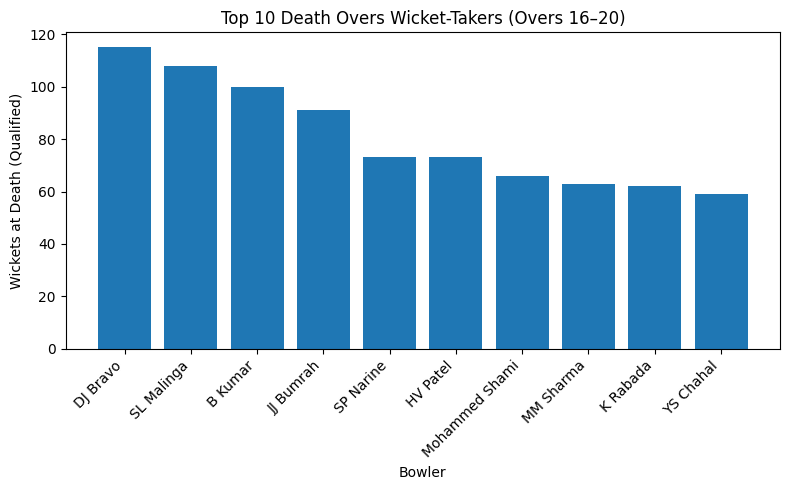

In [ ]:
top10_bowl = bow_death.head(10)
plt.figure(figsize=(8,5))
plt.bar(top10_bowl['bowler'], top10_bowl['wickets'])
plt.title("Top 10 Death Overs Wicket-Takers (Overs 16–20)")
plt.xlabel("Bowler")
plt.ylabel("Wickets at Death (Qualified)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# 4) INSIGHT C: MATCHUPS

# Count a dismissal when the striker is dismissed & it's credited to the bowler.
mb = df[df['is_legal_delivery']].copy()

pair = mb.groupby(['batsman','bowler']).agg(
    balls=('ball','count'),
    runs=('batsman_runs','sum'),
    outs=('player_dismissed', lambda s: (s == s.name[0]).sum())
).reset_index()

pair = pair[pair['balls'] >= 30].copy()
pair['strike_rate'] = 100 * pair['runs'] / pair['balls']
pair['dismissals_per_100'] = 100 * pair['outs'] / pair['balls']

# "Tough" matchups: low SR and at least 2 dismissals
tough = pair[pair['outs'] >= 2].sort_values(['strike_rate','outs'], ascending=[True, False]).head(20)
tough

,batsman,bowler,balls,runs,outs,strike_rate,dismissals_per_100


In [11]:
!pip install plotly

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 16.4 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [plotly]2m1/2 [plotly]


In [ ]:
import plotly.express as px

# Interactive: Powerplay run rate
fig = px.bar(team_pp.head(15), x='batting_team', y='run_rate',
             title='Powerplay Run Rate (Top 15)',
             hover_data=['matches','boundary_pct'])
fig.update_layout(xaxis_title="Team", yaxis_title="Run Rate")
fig.show()

In [13]:
# Interactive: Death overs bowling
fig = px.scatter(bow_death, x='economy', y='wickets', hover_name='bowler',
                 size='overs', title='Death Overs: Wickets vs Economy (bubble=size of overs)')
fig.update_layout(xaxis_title="Economy", yaxis_title="Wickets")
fig.show()